In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
from tools.utils import *
from tools.hom_networks import *
from tools.het_networks import *

In [2]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
num_layers = 2
aggr='mean'
dropout = 0.5
use_skip_connections = True

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

In [4]:
# Preprocess
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [5]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [7]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.8053 | Validation Loss: 1.7994
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0686 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.8043 | Validation Loss: 1.7978
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0786 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.8004 | Validation Loss: 1.7951
Train Acc: 0.1667 | Validation Acc: 0.1889
Train F1: 0.0788 | Validation F1: 0.0861

Epoch 4/30
Train Loss: 1.7962 | Validation Loss: 1.7923
Train Acc: 0.1643 | Validation Acc: 0.1778
Train F1: 0.0844 | Validation F1: 0.0910

Epoch 5/30
Train Loss: 1.7949 | Validation Loss: 1.7904
Train Acc: 0.1762 | Validation Acc: 0.1556
Train F1: 0.1079 | Validation F1: 0.0458

Epoch 6/30
Train Loss: 1.7903 | Validation Loss: 1.7896
Train Acc: 0.1762 | Validation Acc: 0.1778
Train F1: 0.1400 | Validation F1: 0.1017

Epoch 7/30
Train Loss: 1.7907 | Validation Loss: 1.7894
Train Acc: 0.1857 | Validation Acc: 0.1556
Train F1: 0.1407 | Validation F1: 0.0462

Epoch 8/30
Tr

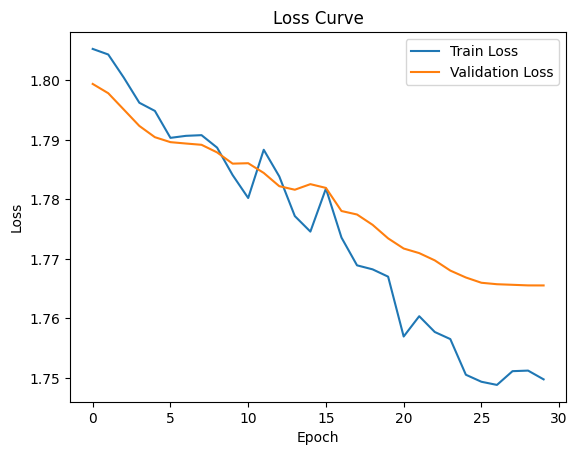

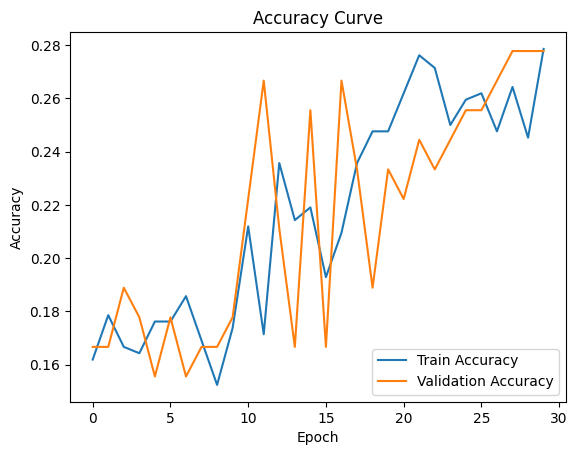

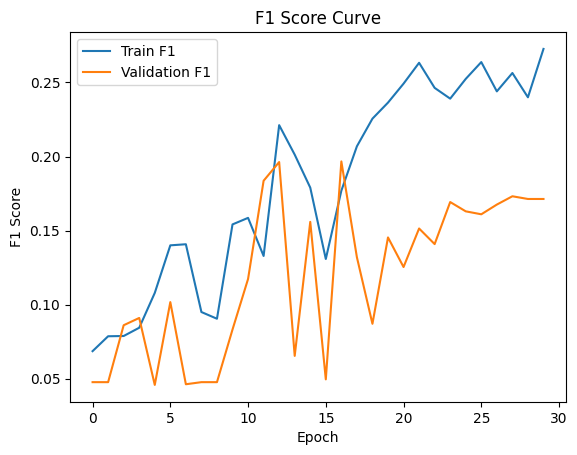

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8053,1.7994,0.1619,0.1667,0.0686,0.0476
1,2,1.8043,1.7978,0.1786,0.1667,0.0786,0.0476
2,3,1.8004,1.7951,0.1667,0.1889,0.0788,0.0861
3,4,1.7962,1.7923,0.1643,0.1778,0.0844,0.0910
4,5,1.7949,1.7904,0.1762,0.1556,0.1079,0.0458
5,6,1.7903,1.7896,0.1762,0.1778,0.1400,0.1017
6,7,1.7907,1.7894,0.1857,0.1556,0.1407,0.0462
7,8,1.7908,1.7892,0.1690,0.1667,0.0950,0.0476
8,9,1.7887,1.7879,0.1524,0.1667,0.0904,0.0476
9,10,1.7841,1.7860,0.1738,0.1778,0.1541,0.0832


In [8]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

In [9]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
num_layers = 2
intra_aggr='sum'
inter_aggr='mean'
dropout = 0.5

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

In [10]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Epoch 1/30
Train Loss: 1.8099 | Validation Loss: 1.7997
Train Acc: 0.1571 | Validation Acc: 0.1000
Train F1: 0.1106 | Validation F1: 0.0516

Epoch 2/30
Train Loss: 1.7952 | Validation Loss: 1.7980
Train Acc: 0.1881 | Validation Acc: 0.1333
Train F1: 0.1371 | Validation F1: 0.0722

Epoch 3/30
Train Loss: 1.7965 | Validation Loss: 1.7952
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.1259 | Validation F1: 0.0770

Epoch 4/30
Train Loss: 1.7915 | Validation Loss: 1.7917
Train Acc: 0.1643 | Validation Acc: 0.1889
Train F1: 0.1361 | Validation F1: 0.1300

Epoch 5/30
Train Loss: 1.7881 | Validation Loss: 1.7881
Train Acc: 0.1690 | Validation Acc: 0.1444
Train F1: 0.1582 | Validation F1: 0.0768

Epoch 6/30
Train Loss: 1.7792 | Validation Loss: 1.7837
Train Acc: 0.1929 | Validation Acc: 0.2000
Train F1: 0.1817 | Validation F1: 0.1119

Epoch 7/30
Train Loss: 1.7688 | Validation Loss: 1.7759
Train Acc: 0.1905 | Validation Acc: 0.2000
Train F1: 0.1624 | Validation F1: 0.1073

Epoch 8/30
Tr

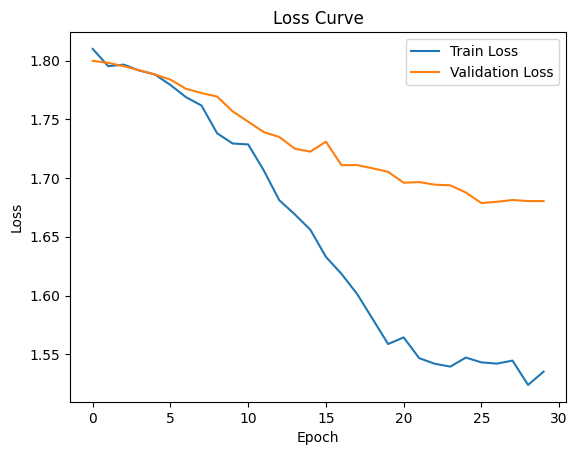

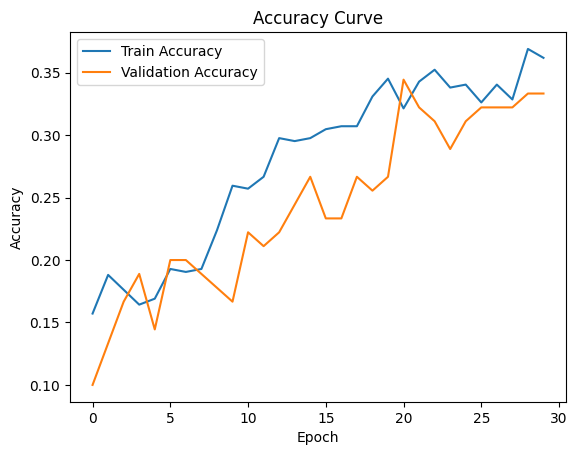

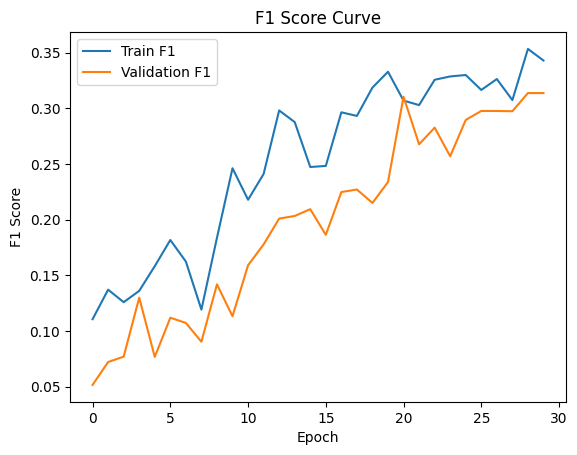

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8099,1.7997,0.1571,0.1000,0.1106,0.0516
1,2,1.7952,1.7980,0.1881,0.1333,0.1371,0.0722
2,3,1.7965,1.7952,0.1762,0.1667,0.1259,0.0770
3,4,1.7915,1.7917,0.1643,0.1889,0.1361,0.1300
4,5,1.7881,1.7881,0.1690,0.1444,0.1582,0.0768
5,6,1.7792,1.7837,0.1929,0.2000,0.1817,0.1119
6,7,1.7688,1.7759,0.1905,0.2000,0.1624,0.1073
7,8,1.7617,1.7723,0.1929,0.1889,0.1192,0.0904
8,9,1.7381,1.7693,0.2238,0.1778,0.1837,0.1419
9,10,1.7294,1.7567,0.2595,0.1667,0.2461,0.1133


In [11]:
experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

In [12]:
def find_learning_rate(model, optimizer, criterion, dataloader, 
                      start_lr=1e-5, end_lr=1e-2, num_iter=100, 
                      smooth_coef=0.05, device=None):
    """
    Learning rate finder inspired by Fast.ai's lr_find
    
    Args:
        model: PyTorch model
        optimizer: Initialized optimizer
        criterion: Loss function
        dataloader: Training dataloader
        start_lr: Starting learning rate
        end_lr: Maximum learning rate to test
        num_iter: Number of iterations to run
        smooth_coef: Loss smoothing coefficient (0-1)
        device: Device to use (default: model's device)
    
    Returns:
        lrs: List of learning rates tested
        losses: List of smoothed losses
    """
    # Save original model and optimizer states
    orig_model = deepcopy(model.state_dict())
    orig_optimizer = deepcopy(optimizer.state_dict())
    
    # Device setup
    device = device or next(model.parameters()).device
    model.to(device)
    
    # Initialize learning rate
    lr = start_lr
    factor = (end_lr / start_lr) ** (1 / num_iter)
    
    # Set up optimizer with initial LR
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    losses = []
    lrs = []
    best_loss = None
    iterator = iter(dataloader)
    
    model.train()
    for iteration in range(num_iter):
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataloader)
            batch = next(iterator)
        
        # Move data to device
        batch = batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y) 
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Smooth loss and track
        current_loss = loss.item()
        if best_loss is None:
            best_loss = current_loss
        else:
            current_loss = smooth_coef * current_loss + (1 - smooth_coef) * best_loss
            best_loss = current_loss
        
        losses.append(current_loss)
        lrs.append(lr)
        
        # Update learning rate
        lr *= factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Early stopping if loss explodes
        if current_loss > 4 * best_loss or np.isnan(current_loss):
            break
    
    # Restore original model/optimizer state
    model.load_state_dict(orig_model)
    optimizer.load_state_dict(orig_optimizer)
    
    return lrs, losses

def plot_lr_find(lrs, losses, skip_begin=10, skip_end=5):
    """
    Plot learning rate finder results and suggest optimal LR
    
    Args:
        lrs: List of learning rates
        losses: List of losses
        skip_begin: Number of initial points to skip
        skip_end: Number of final points to skip
    """
    # Calculate gradients
    gradients = np.gradient(losses)
    
    # Find minimum gradient (steepest negative slope)
    min_grad_idx = np.argmin(gradients[skip_begin:-skip_end]) + skip_begin
    optimal_lr = lrs[min_grad_idx]
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.scatter(optimal_lr, losses[min_grad_idx], c='red', 
                label=f'Suggested LR: {optimal_lr:.2E}')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return optimal_lr

In [13]:
def create_edge_index(data):
    data = data.clone()
    if hasattr(data, 'edge_index_union') and data['edge_index_union'] is not None:
        data['edge_index'] = data['edge_index_union']
        data.pop('edge_index_free', None)
        data.pop('edge_index_bound', None)
        data.pop('pos_free', None)
        data.pop('pos_bound', None)
        data.pop('edge_index_union', None)
    return data

hom_dataset = torch.load('data/PSCDB/hom_pscdb_graphs.pt', weights_only=False)
hom_dataset_reindexed = [create_edge_index(hom_data) for hom_data in hom_dataset]
train_loader = get_train_loader(42, hom_dataset_reindexed, 8)

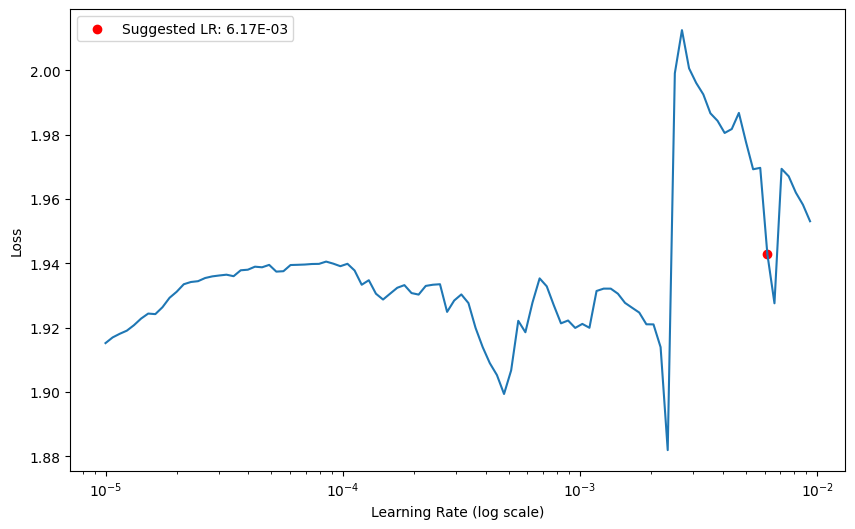

Suggested learning rate: 0.006165950018614819


In [14]:
# Initialize model, optimizer, and dataloader
model = HomoGNN_GraphConv(128, 7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = torch.nn.CrossEntropyLoss()

# Find learning rates
lrs, losses = find_learning_rate(model, optimizer, criterion, train_loader)

# Plot results and get suggested LR
optimal_lr = plot_lr_find(lrs, losses)
print(f"Suggested learning rate: {optimal_lr}")